In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings

from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp

import time
import matplotlib.pyplot as plt

In [47]:
noise_var = 4.
dt = 0.2
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = LorenzExp(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=32,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

trajectory_model = DataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 2500,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-15,
    init_alpha = 100.,
)

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=AlternatingActiveSetLMSolver(beta_reg=0.00001,solver_settings=optsettings,colloc_weight_scale = 10.),
    feature_names=expdata.feature_names
)
model.fit(
    expdata.t_train,
    expdata.x_train,
    expdata.t_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.e-08, dtype=float64), 'data_weight': Array(99.9999, dtype=float64), 'colloc_weight': Array(999.999, dtype=float64)}
Warm Start


  0%|          | 0/2500 [00:00<?, ?it/s]

Iteration 0, loss = 3.851e+11, gradnorm = 7.668e+13, alpha = 100.0, improvement_ratio = 0.4812
Iteration 1, loss = 3.656e+11, gradnorm = 3.533e+14, alpha = 607.5, improvement_ratio = 0.05065
Iteration 2, loss = 3.425e+11, gradnorm = 2.982e+14, alpha = 405.0, improvement_ratio = 0.0631
Iteration 3, loss = 2.548e+11, gradnorm = 1.753e+15, alpha = 100.0, improvement_ratio = 0.2561
Iteration 4, loss = 2.344e+11, gradnorm = 2.639e+14, alpha = 120.0, improvement_ratio = 0.07998
Iteration 5, loss = 2.939e+10, gradnorm = 2.813e+14, alpha = 83.33, improvement_ratio = 0.8747
Iteration 200, loss = 2.133e+06, gradnorm = 1.405e+09, alpha = 10.56, improvement_ratio = 0.7422
Iteration 400, loss = 2.13e+06, gradnorm = 4.472e+08, alpha = 0.0009674, improvement_ratio = 0.8954
Iteration 600, loss = 2.128e+06, gradnorm = 8.839e+06, alpha = 8.333e-16, improvement_ratio = 1.0
Iteration 800, loss = 2.127e+06, gradnorm = 5.101e+06, alpha = 8.333e-16, improvement_ratio = 1.0
Iteration 1000, loss = 2.126e+06, g

In [48]:
model.print()

(x)' = 18.758 1 + -9.124 x + 9.431 y + -0.856 z
(y)' = -2.455 1 + 28.503 x + -1.126 y + -1.008 x z
(z)' = 0.491 1 + -0.566 y + -2.613 z + 1.012 x y


In [49]:
metrics

{'coeff_mets': {'precision': 0.5833333333333334,
  'recall': 1.0,
  'f1': 0.7368421052631579,
  'coeff_rel_l2': 0.6022276963804866,
  'coeff_rmse': 3.466710384382715,
  'coeff_mae': 0.8424309015416095},
 'data_mets': {'mse': Array(29.19098033, dtype=float64),
  'rmse': np.float64(5.402867787316422),
  'mae': np.float64(3.6016414726565644),
  'max_abs_error': np.float64(30.358209076390082),
  'normalized_mse': Array(0.00750344, dtype=float64),
  'relative_l2_error': np.float64(0.08660860448043457)}}

In [50]:
xpred = model.predict_state(expdata.t_true)

jnp.mean((xpred - expdata.x_true)**2)/jnp.var(expdata.x_true)

Array(0.00256092, dtype=float64)

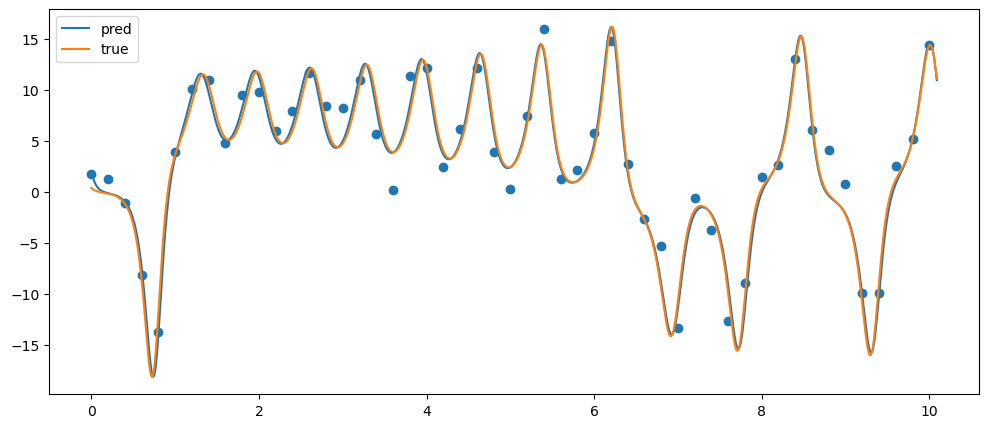

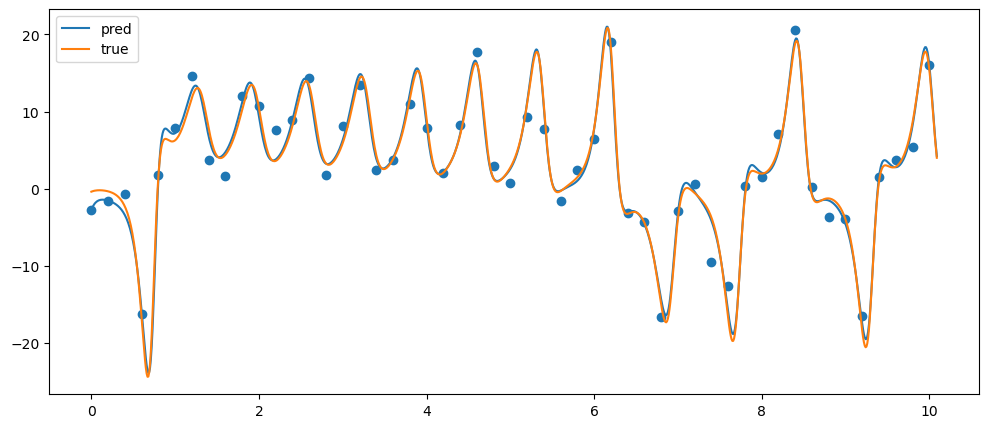

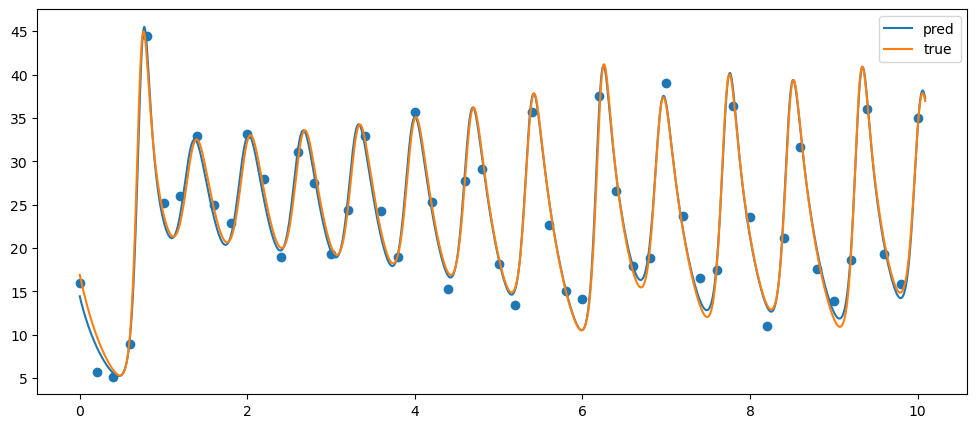

In [51]:
xpred = model.predict_state(expdata.t_true)
for index in range(3):
    plt.figure(figsize=(12,5))
    plt.plot(expdata.t_true,xpred[:,index],label = 'pred')
    plt.plot(expdata.t_true,expdata.x_true[:,index],label = 'true')
    plt.scatter(expdata.t_train,expdata.x_train[:,index])
    plt.legend()
    plt.show()

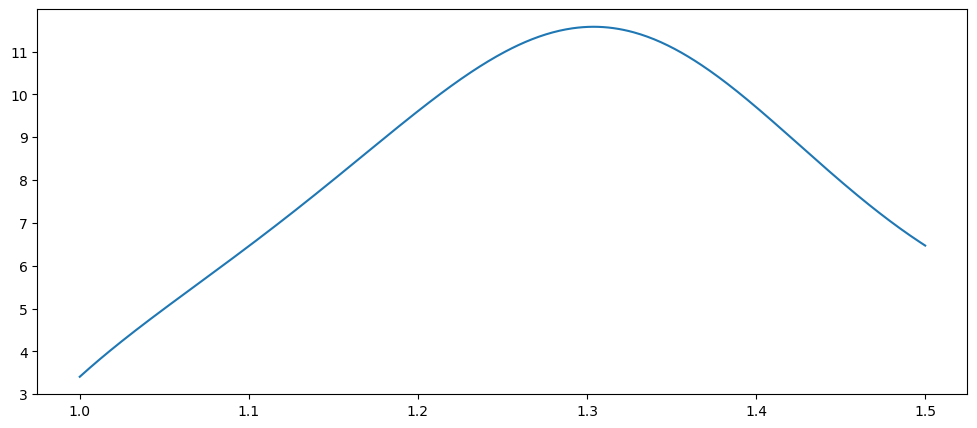

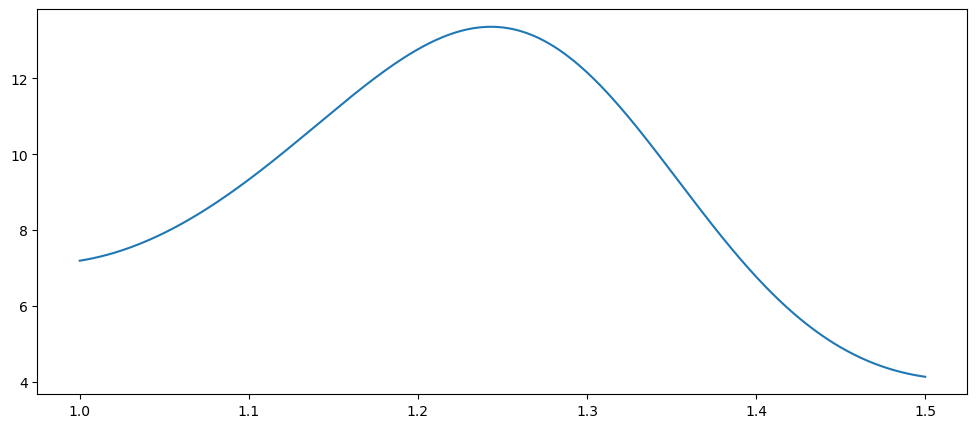

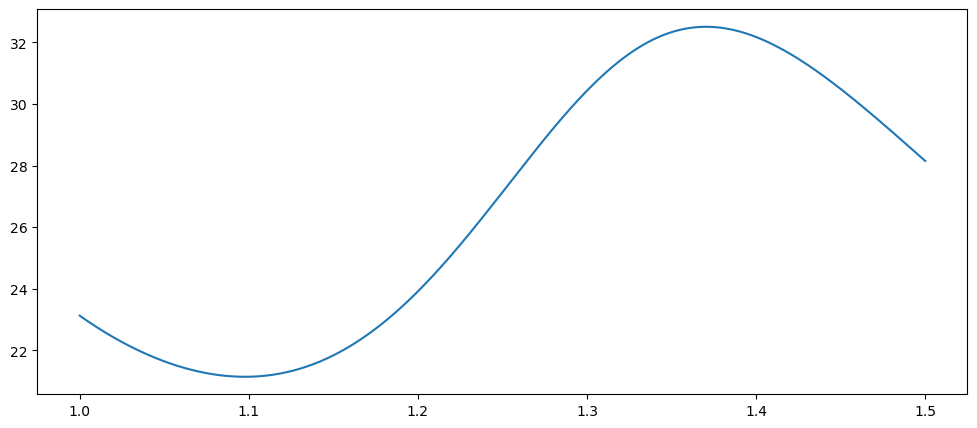

In [52]:
xpred = model.predict_state(jnp.linspace(1,1.5,500))
for index in range(3):
    plt.figure(figsize=(12,5))
    plt.plot(jnp.linspace(1,1.5,500),xpred[:,index],label = 'pred')
